<a href="https://colab.research.google.com/github/mirnanoukari/Theoretical-Mechanics/blob/main/TM_Research_Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1**

## Theoretical Mechanics

Mirna Alnoukari

#**Tools**
Python, Colab notebook \\
libraries: [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/)

#**Algorithm Description**

Our goal is to find the minimum time to pass the trajectory with respect to some constraints. Therefore, the proposed solution is to draw the trajectory, divide it by i points, approximate the motion between two points as a linear motion and calculate the velocity and time between each two adjacent points.


### **Splitting the trajectory:**
The direct method to divide axes x in equal parts, and calculate y for each of those x's. In general, we make the curve parametrized with a third parameter s, and we write x(s) and y(s). then we split s, and calculate x on all s'es and y on all s'es. this way, we can solve the problem with any curve.

### **Approximation:**
For each two points, we approximated the motion to a linear motion to simplify our calculations. When those points are in the limit and closer to each other this approximation will be more realistic.


### **Constraints:**
We want to find variables t1, t2, t3... which are the time needed to go from one point to the next one, with the contraints we have:
$${a^\tau} \leq 10  \space {m.s^{-2}}$$    
$${a^n} \leq 6 \space {m.s^{-2}} $$ \\
$$ {V \leq 1.5 \space {m.s^{-1}}} $$

This is an optimization problem, and there are many ways to solve it with, our solution was basically to assume that the time is in a form of discrete segments by 0.001 and solve it with dynamic programming.

The following is the way we calculated time between each two points:

![]<img src="https://drive.google.com/uc?export=view&id=1HpY3qvM17MljBrD-WAcug0v3vWpBsVnd" width="400" height="250" />

$$ \vec{V_i} = \frac{\vec{r_i} - \vec{r_{i-1}}}{t_i}$$
$$ \vec{V_{i+1}} = \frac{\vec{r_{i+1}} - \vec{r_{i}}}{t_{i+1}}$$


$$|\vec{V_i}|\leq 1.5 \Longleftrightarrow \frac{|\vec{r_{i+1}} - \vec{r_{i}}|}{t_{i+1}} \leq 1.5$$

$$Let |R_{i+1}| ={|\vec{r_{i+1}} - \vec{r_{i}}|}$$
$$ \Longleftrightarrow
t_{i+1} \geq \frac{|R_{i+1}|}{1.5}$$


$$ \vec{a_{i+1}} = \frac{\vec{V_{i+1}} - \vec{V_i}}{t_{i+1}}$$
$$ \vec{a_{i+1}}= \frac{\frac{\vec{R_{i+1}}}{t_{i+1}} - \frac{\vec{R_i}}{t_i}}{{t_{i+1}} }  =  \frac{\vec{R_{i+1}}}{t_{i+1}^2} - \frac{\vec{R_i}}{t_{i+1} \cdot t_i} $$

$${a_{i+1}^\tau} = \frac{{R_{i+1}} \cdot \cos{\theta_i} }{t_{i+1}^2} - \frac{\vec{R_i}}{t_{i+1} \cdot t_i} \leq 10
$$    

$${a_{i+1}^n} = \frac{{R_{i+1}} \cdot \sin{\theta_i} }{t_{i}^2} \leq 6
\Longleftrightarrow $$    

$$t_i \geq \sqrt{\frac{{R_{i+1}} \cdot \sin{\theta_i} }{6}} 
$$  

$$\vec{V_{n+1}} = \vec{0}$$



In [1]:
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pickle

In [2]:
sys.setrecursionlimit(2 ** 16)

In [3]:
A = 1
om = 3
theta = 0.2

a_t_mag_max = 10
a_n_mag_max = 6
v_mag_max = 1.5

def x(s):
  return 4 * s

def y(s):
  return A * np.sin(om * x(s) + theta)

def r(s):
  return np.array([x(s), y(s)]).transpose()

In [4]:
def best_drive(r_quantum, a_t_mag_max, a_n_mag_max, v_mag_max, dt = 0.001, max_t_per_step = 0.1):
  n = len(r_quantum) - 1
  dt_count_max = int(max_t_per_step / dt)

  R = np.zeros((n + 2, 2))
  for i in range(n - 1):
    R[i + 1] = r_quantum[i + 1] - r_quantum[i]  

  def check_next_v(prev_v, next_t, next_v):
    next_v_mag_sqr = np.dot(next_v, next_v)
    
    if next_v_mag_sqr > v_mag_max ** 2:
      return False
    
    a = (next_v - prev_v) / next_t
    a_t_mag_sqr = np.dot(a, prev_v) ** 2 / np.dot(prev_v, prev_v) if np.any(prev_v) else np.dot(a, a)
    a_n_mag_sqr = np.dot(a, a) - a_t_mag_sqr
    
    if a_t_mag_sqr > a_t_mag_max ** 2 or a_n_mag_sqr > a_n_mag_max ** 2:
      return False
    
    return True
  
  flagged = np.zeros((n + 2, dt_count_max), dtype = np.bool)
  memo_table = np.zeros((n + 2, dt_count_max), dtype = np.int)
  optimal = np.zeros((n + 2, dt_count_max), dtype = np.int)

  for i in tqdm(range(n, -1, -1)):
    for prev_dt_count in range(0, dt_count_max):
      memo_table[i, prev_dt_count] = n * dt_count_max
      prev_v = R[i] / (prev_dt_count * dt) if prev_dt_count > 0 else np.zeros(2)
      for next_dt_count in range(1, dt_count_max):
        next_t = next_dt_count * dt
        next_v = R[i + 1] / next_t
        sol = next_dt_count + memo_table[i + 1, next_dt_count]
        if memo_table[i, prev_dt_count] > sol and check_next_v(prev_v, next_t, next_v):
          memo_table[i, prev_dt_count] = sol
          optimal[i, prev_dt_count] = next_dt_count
  
  ret = np.zeros(n)
  prev_dt_count = 0
  for i in range(n):
    ret[i] = optimal[i, prev_dt_count]
    prev_dt_count = optimal[i, prev_dt_count]
  return ret, memo_table

In [5]:
N_s = 2 ** 8
s_quantum = np.linspace(0, 1, N_s)

r_quantum = r(s_quantum)

100%|██████████| 256/256 [11:39<00:00,  2.73s/it]


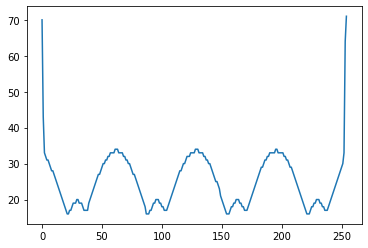

In [6]:
time_steps, table = best_drive(r_quantum, a_t_mag_max, a_n_mag_max, v_mag_max, dt = 0.001, max_t_per_step = 1)
plt.plot(time_steps)
plt.show()

In [7]:
pickle.dump(time_steps, open('time_steps', 'wb'))
pickle.dump(table, open('optimal table', 'wb'))

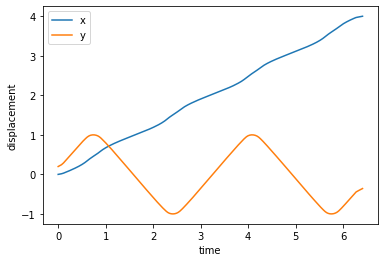

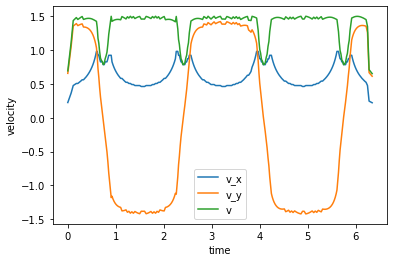

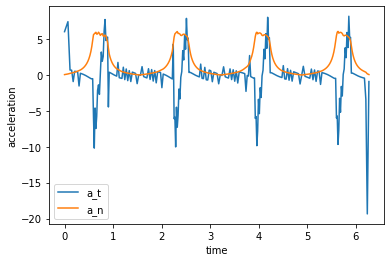

In [8]:
t = np.zeros(N_s)
t[1:] = time_steps
t *= 0.001
t = np.cumsum(t)

plt.plot(t, r_quantum[:, 0], label = 'x')
plt.plot(t, r_quantum[:, 1], label = 'y')
plt.xlabel('time')
plt.ylabel('displacement')
plt.legend()
plt.show()

v = np.diff(r_quantum, axis = 0)
dt = np.diff(t)
for i in range(v.shape[0]):
  v[i] /= dt[i]

plt.plot(t[:-1], v[:, 0], label = 'v_x')
plt.plot(t[:-1], v[:, 1], label = 'v_y')
plt.plot(t[:-1], lg.norm(v, axis = 1), label = 'v')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()

a = np.diff(v, axis = 0)
for i in range(a.shape[0]):
  a[i] /= dt[i]
a_mag = lg.norm(a, axis = 1)

a_t = np.zeros(a.shape[0])
for i in range(a_t.shape[0]):
  a_t[i] = np.dot(a[i], v[i]) / lg.norm(v[i])
a_n = np.zeros(a.shape[0])
for i in range(a_n.shape[0]):
  a_n[i] = np.sqrt(a_mag[i] ** 2 - a_t[i] ** 2)

plt.plot(t[:-2], a_t, label = 'a_t')
plt.plot(t[:-2], a_n, label = 'a_n')
plt.legend()
plt.xlabel('time')
plt.ylabel('acceleration')
plt.show()